In [1]:
from PIL import Image
from numpy import asarray, concatenate, cov, zeros, random
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from functools import reduce
from random import randint
from numba import jit, float32

In [2]:
# load the image
image = Image.open('test02.jpg').resize((256, 256))

#print image mode
print(image.mode)

# convert image to numpy array (256, 256, 3)
img_tenzor = asarray(image)

# summarize shape
shape = img_tenzor.shape
print(f' img shape {shape}')

RGB
 img shape (256, 256, 3)


### cut examples 2 for image segments

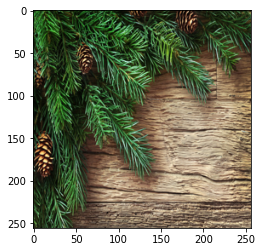

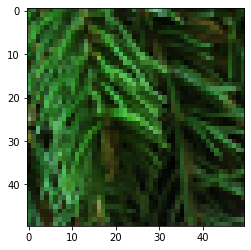

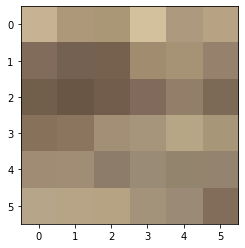

In [3]:
segment_1,  segment_2= img_tenzor[:50, :50], img_tenzor[250:, 250:]

plt.imshow(img_tenzor)
plt.show()
plt.imshow(segment_1, interpolation='nearest')
plt.show()
plt.imshow(segment_2, interpolation='nearest')
plt.show()

In [4]:
segment_1 = concatenate((segment_1), axis=0 )
segment_1_mean = segment_1.mean(axis=0)
segment_1_cov = cov(segment_1, rowvar=False)

print(f'segment_1 MEAN  \t{segment_1_mean}\n')
print(f'segment_1 COV MATRIX\n {segment_1_cov}\n')
print(f'segment_1 COV MATRIX shape \t {segment_1_cov.shape}')

segment_1 MEAN  	[35.1428 68.3844 25.356 ]

segment_1 COV MATRIX
 [[ 389.68948395  720.17997967  351.82269228]
 [ 720.17997967 1776.58887219  791.35809684]
 [ 351.82269228  791.35809684  429.324994  ]]

segment_1 COV MATRIX shape 	 (3, 3)


In [5]:
segment_2 = concatenate((segment_2), axis=0 )
segment_2_mean = segment_2.mean(axis=0)
segment_2_cov = cov(segment_2, rowvar=False)

print(f'segment_2 MEAN  \t{segment_2_mean}\n')
print(f'segment_2 COV MATRIX\n {segment_2_cov}\n')
print(f'segment_2 COV MATRIX shape \t {segment_2_cov.shape}')

segment_2 MEAN  	[153.91666667 134.69444444 110.66666667]

segment_2 COV MATRIX
 [[660.13571429 669.77380952 538.6       ]
 [669.77380952 683.70396825 550.66666667]
 [538.6        550.66666667 450.62857143]]

segment_2 COV MATRIX shape 	 (3, 3)


### For each pixel put initial segment type

In [6]:
dist_segm1_color = multivariate_normal(mean=segment_1_mean, cov=segment_1_cov)
dist_segm2_color = multivariate_normal(mean=segment_2_mean, cov=segment_2_cov)

def likelyhood(pixel_color_list, dist_segm1_color, dist_segm2_color):
    
    pdf_1 = dist_segm1_color.pdf(pixel_color_list)
    pdf_2 = dist_segm2_color.pdf(pixel_color_list)
    
#     if pdf_1 > pdf_2:
    return randint(0,1), pdf_1, pdf_2  #marker color randomly and probs of belonging to 1 and 2 classes
#     else:
#         return 0, pdf_1, pdf_2 
    

print(f' test for pixel (253, 253):\n {likelyhood(img_tenzor[253][253], dist_segm1_color, dist_segm2_color)}')

 test for pixel (253, 253):
 (0, 6.488698812467046e-31, 0.00031284572201125186)


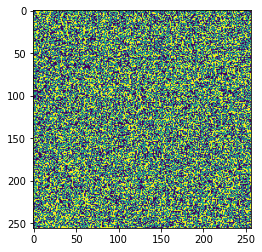

In [7]:
marked_image_data  = zeros(shape=img_tenzor.shape , dtype=float)

for i in range(shape[0]):
    for j in range(shape[1]):
        marked_image_data[i][j] = likelyhood(img_tenzor[i][j], dist_segm1_color, dist_segm2_color)
    
plt.imshow(marked_image_data[:, :,0])
plt.show()

### find neighbors and sampling

In [8]:
@jit(nopython=True)
def find_neighbors(matrix, i, j):
    neighbors = [matrix[i+step[0], j+step[1], 0] for step in
                      [(0,-1), (0,1), (-1,0), (1,0)] 
                    if ((0 <= i+step[0] < len(matrix)) and (0 <= j+step[1] < len(matrix[0])))]
    return neighbors



@jit(nopython=True)
def sampling(matrix, eps, shape):
    
    new_matrix = zeros(shape=shape, dtype=float32)
    for i in range(shape[0]):
        for j in range(shape[1]):
            neighbors = find_neighbors(matrix, i, j)
            k1 = matrix[i,j][1]*reduce(lambda a, b: a*b,[(1 - eps) if x == 1 else eps for x in neighbors])
            k2 = matrix[i,j][2]*reduce(lambda a, b: a*b,[(1 - eps) if x == 0 else eps for x in neighbors])
            prob_k1, prob_k2 = k1/(k1+k2), k2/(k1+k2)
            new_matrix[i,j,0] = (1 if prob_k1 > prob_k2 else 0)
            new_matrix[i,j,1:]= prob_k1, prob_k2
    return new_matrix

In [9]:
# find_neighbors function test
x = random.randint(5, size=(3,3,1))
print(x)

print(x[1,2])
print(find_neighbors(x, 1, 2))

[[[1]
  [3]
  [1]]

 [[4]
  [3]
  [0]]

 [[1]
  [1]
  [4]]]
[0]
[3, 1, 4]


In [18]:
#sampling function test
x = random.randint(1,3, size=(3,3,3))
print(x)

sampling(x, 0.5, (3,3,3))

[[[1 2 1]
  [2 1 1]
  [2 1 2]]

 [[1 1 2]
  [2 2 2]
  [1 2 2]]

 [[2 1 1]
  [2 2 1]
  [2 2 2]]]


array([[[1.        , 0.6666667 , 0.33333334],
        [0.        , 0.5       , 0.5       ],
        [0.        , 0.33333334, 0.6666667 ]],

       [[0.        , 0.33333334, 0.6666667 ],
        [0.        , 0.5       , 0.5       ],
        [0.        , 0.5       , 0.5       ]],

       [[0.        , 0.5       , 0.5       ],
        [1.        , 0.6666667 , 0.33333334],
        [0.        , 0.5       , 0.5       ]]], dtype=float32)

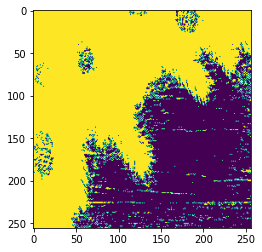

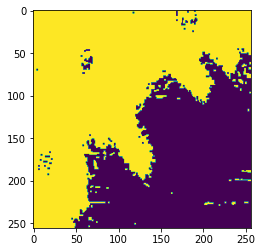

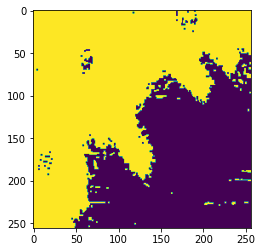

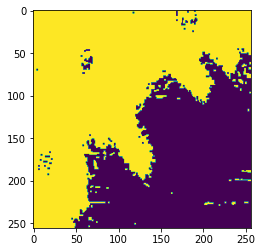

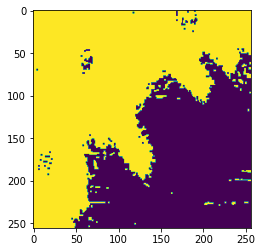

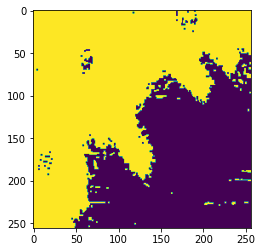

CPU times: user 16.4 s, sys: 294 ms, total: 16.7 s
Wall time: 20.2 s


In [10]:
%%time

for i in range(101):
    marked_image_data = sampling(marked_image_data, 0.001, shape)
    if i%20 == 0:
        plt.imshow(marked_image_data[:,:,0])
        plt.show()